# Import of needed libraries

In [7]:
#import libraries
import datetime
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

# Define Stocks and Dates

In [8]:
stocks = ["BNTX", "AAPL", "TSLA"]
s_1 = stocks[0]
s_2 = stocks[1]
s_3 = stocks[2]


end = datetime.datetime.today()
date200 = datetime.timedelta(days=365)
start200 = end - date200
start = start200.strftime("%Y-%m-%d")
data = pdr.DataReader(stocks, 'yahoo', start, end)

# Trading strategy 

In [9]:
short_window = 20
long_window = 100
signals = pd.DataFrame(index=data.index)
signals['signal1'] = 0.0
signals['signal2'] = 0.0
signals['signal3'] = 0.0
# calculate short and long mvag
signals['short_mavg1'] = data['Close'][stocks[0]].rolling(window=short_window, min_periods=1, center=False).mean()
signals['short_mavg2'] = data['Close'][stocks[1]].rolling(window=short_window, min_periods=1, center=False).mean()
signals['short_mavg3'] = data['Close'][stocks[2]].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_mavg1'] = data['Close'][stocks[0]].rolling(window=long_window, min_periods=1, center=False).mean()
signals['long_mavg2'] = data['Close'][stocks[1]].rolling(window=long_window, min_periods=1, center=False).mean()
signals['long_mavg3'] = data['Close'][stocks[2]].rolling(window=long_window, min_periods=1, center=False).mean()
# Create signals where shortmavg is > longmavg
signals['signal1'][short_window:] = np.where(signals['short_mavg1'][short_window:]
                                            > signals['long_mavg1'][short_window:], 1.0, 0.0)
signals['signal2'][short_window:] = np.where(signals['short_mavg2'][short_window:]
                                            > signals['long_mavg2'][short_window:], 1.0, 0.0)
signals['signal3'][short_window:] = np.where(signals['short_mavg3'][short_window:]
                                            > signals['long_mavg3'][short_window:], 1.0, 0.0)
# Generate trading orders
signals['positions1'] = signals['signal1'].diff()
signals['positions2'] = signals['signal2'].diff()
signals['positions3'] = signals['signal3'].diff()

print(signals)
print(signals.info())


            signal1  signal2  signal3  ...  positions1  positions2  positions3
Date                                   ...                                    
2019-12-18      0.0      0.0      0.0  ...         NaN         NaN         NaN
2019-12-19      0.0      0.0      0.0  ...         0.0         0.0         0.0
2019-12-20      0.0      0.0      0.0  ...         0.0         0.0         0.0
2019-12-23      0.0      0.0      0.0  ...         0.0         0.0         0.0
2019-12-24      0.0      0.0      0.0  ...         0.0         0.0         0.0
...             ...      ...      ...  ...         ...         ...         ...
2020-12-11      1.0      1.0      1.0  ...         0.0         0.0         0.0
2020-12-14      1.0      1.0      1.0  ...         0.0         0.0         0.0
2020-12-15      1.0      1.0      1.0  ...         0.0         0.0         0.0
2020-12-16      1.0      1.0      1.0  ...         0.0         0.0         0.0
2020-12-17      1.0      1.0      1.0  ...         0

# Trading in virtual Portfolio 

In [10]:
# backtester
# Set the initial capital
initial_capital = float(500000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['stock'] = 100 * signals['signal1'] + 100 * signals['signal2'] + 100 * signals['signal3']


# Initialize the portfolio with value owned
portfolio = positions.multiply(data['Adj Close'][stocks[0]], axis=0)
portfolio = positions.multiply(data['Adj Close'][stocks[1]], axis=0)
portfolio = positions.multiply(data['Adj Close'][stocks[2]], axis=0)

# Store the difference in shares owned
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['Holdings - Stock 1'] = (positions.multiply(data['Adj Close'][stocks[0]], axis=0)).sum(axis=1)
portfolio['Holdings - Stock 2'] = (positions.multiply(data['Adj Close'][stocks[1]], axis=0)).sum(axis=1)
portfolio['Holdings - Stock 3'] = (positions.multiply(data['Adj Close'][stocks[2]], axis=0)).sum(axis=1)
portfolio['Total Holdings'] = portfolio['Holdings - Stock 1'] + portfolio['Holdings - Stock 2'] + portfolio['Holdings - Stock 3']
# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(data['Adj Close'][stocks[0]], axis=0)).sum(axis=1).cumsum()\
                    -(pos_diff.multiply(data['Adj Close'][stocks[1]], axis=0)).sum(axis=1).cumsum()\
                    -(pos_diff.multiply(data['Adj Close'][stocks[2]], axis=0)).sum(axis=1).cumsum()
# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['Total Holdings']
# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Plot Portfolio

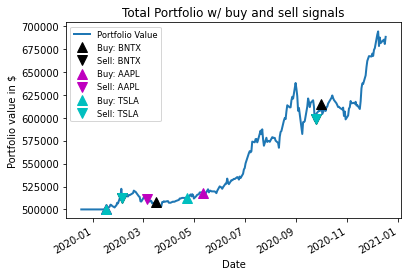

In [11]:
# plot portfolio overview
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)
# Plot the "buy" trades against the equity curve - Stock 1
ax1.plot(portfolio.loc[signals.positions1 == 1.0].index,
        portfolio.total[signals.positions1 == 1.0],
        '^', markersize=10, color='k')
# Plot the "sell" trades against the equity curve - Stock 1
ax1.plot(portfolio.loc[signals.positions1 == -1.0].index,
        portfolio.total[signals.positions1 == -1.0],
        'v', markersize=10, color='k')
# Plot the "buy" trades against the equity curve - Stock 2
ax1.plot(portfolio.loc[signals.positions2 == 1.0].index,
        portfolio.total[signals.positions2 == 1.0],
        '^', markersize=10, color='m')
# Plot the "sell" trades against the equity curve - Stock 2
ax1.plot(portfolio.loc[signals.positions2 == -1.0].index,
        portfolio.total[signals.positions2 == -1.0],
        'v', markersize=10, color='m')
# Plot the "buy" trades against the equity curve - Stock 2
ax1.plot(portfolio.loc[signals.positions3 == 1.0].index,
        portfolio.total[signals.positions3 == 1.0],
        '^', markersize=10, color='c')
# Plot the "sell" trades against the equity curve - Stock 2
ax1.plot(portfolio.loc[signals.positions1 == -1.0].index,
        portfolio.total[signals.positions1 == -1.0],
        'v', markersize=10, color='c')
plt.title("Total Portfolio w/ buy and sell signals")
plt.legend(('Portfolio Value', "Buy: %s" %s_1 ,'Sell: %s' %s_1,'Buy: %s'
            %s_2,'Sell: %s' %s_2, 'Buy: %s' %s_3,'Sell: %s' %s_3), fontsize="small")
plt.show()